In [5]:
!pip install pandas numpy matplotlib scikit-learn

In [6]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import math
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



# ΜΕΡΟΣ 1

## Ερώτηση 1

         type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0       white            7.0             0.270         0.36            20.7   
1     unknown            6.3             0.300         0.34             1.6   
2       white            8.1             0.280         0.40             6.9   
3     unknown            7.2             0.230         0.32             8.5   
4     unknown            7.2             0.230         0.32             8.5   
...       ...            ...               ...          ...             ...   
6492      red            6.2             0.600         0.08             2.0   
6493      red            5.9             0.550         0.10             2.2   
6494  unknown            6.3             0.510         0.13             2.3   
6495      red            5.9             0.645         0.12             2.0   
6496      red            6.0             0.310         0.47             3.6   

      chlorides  free sulfur dioxide  total sulfur 

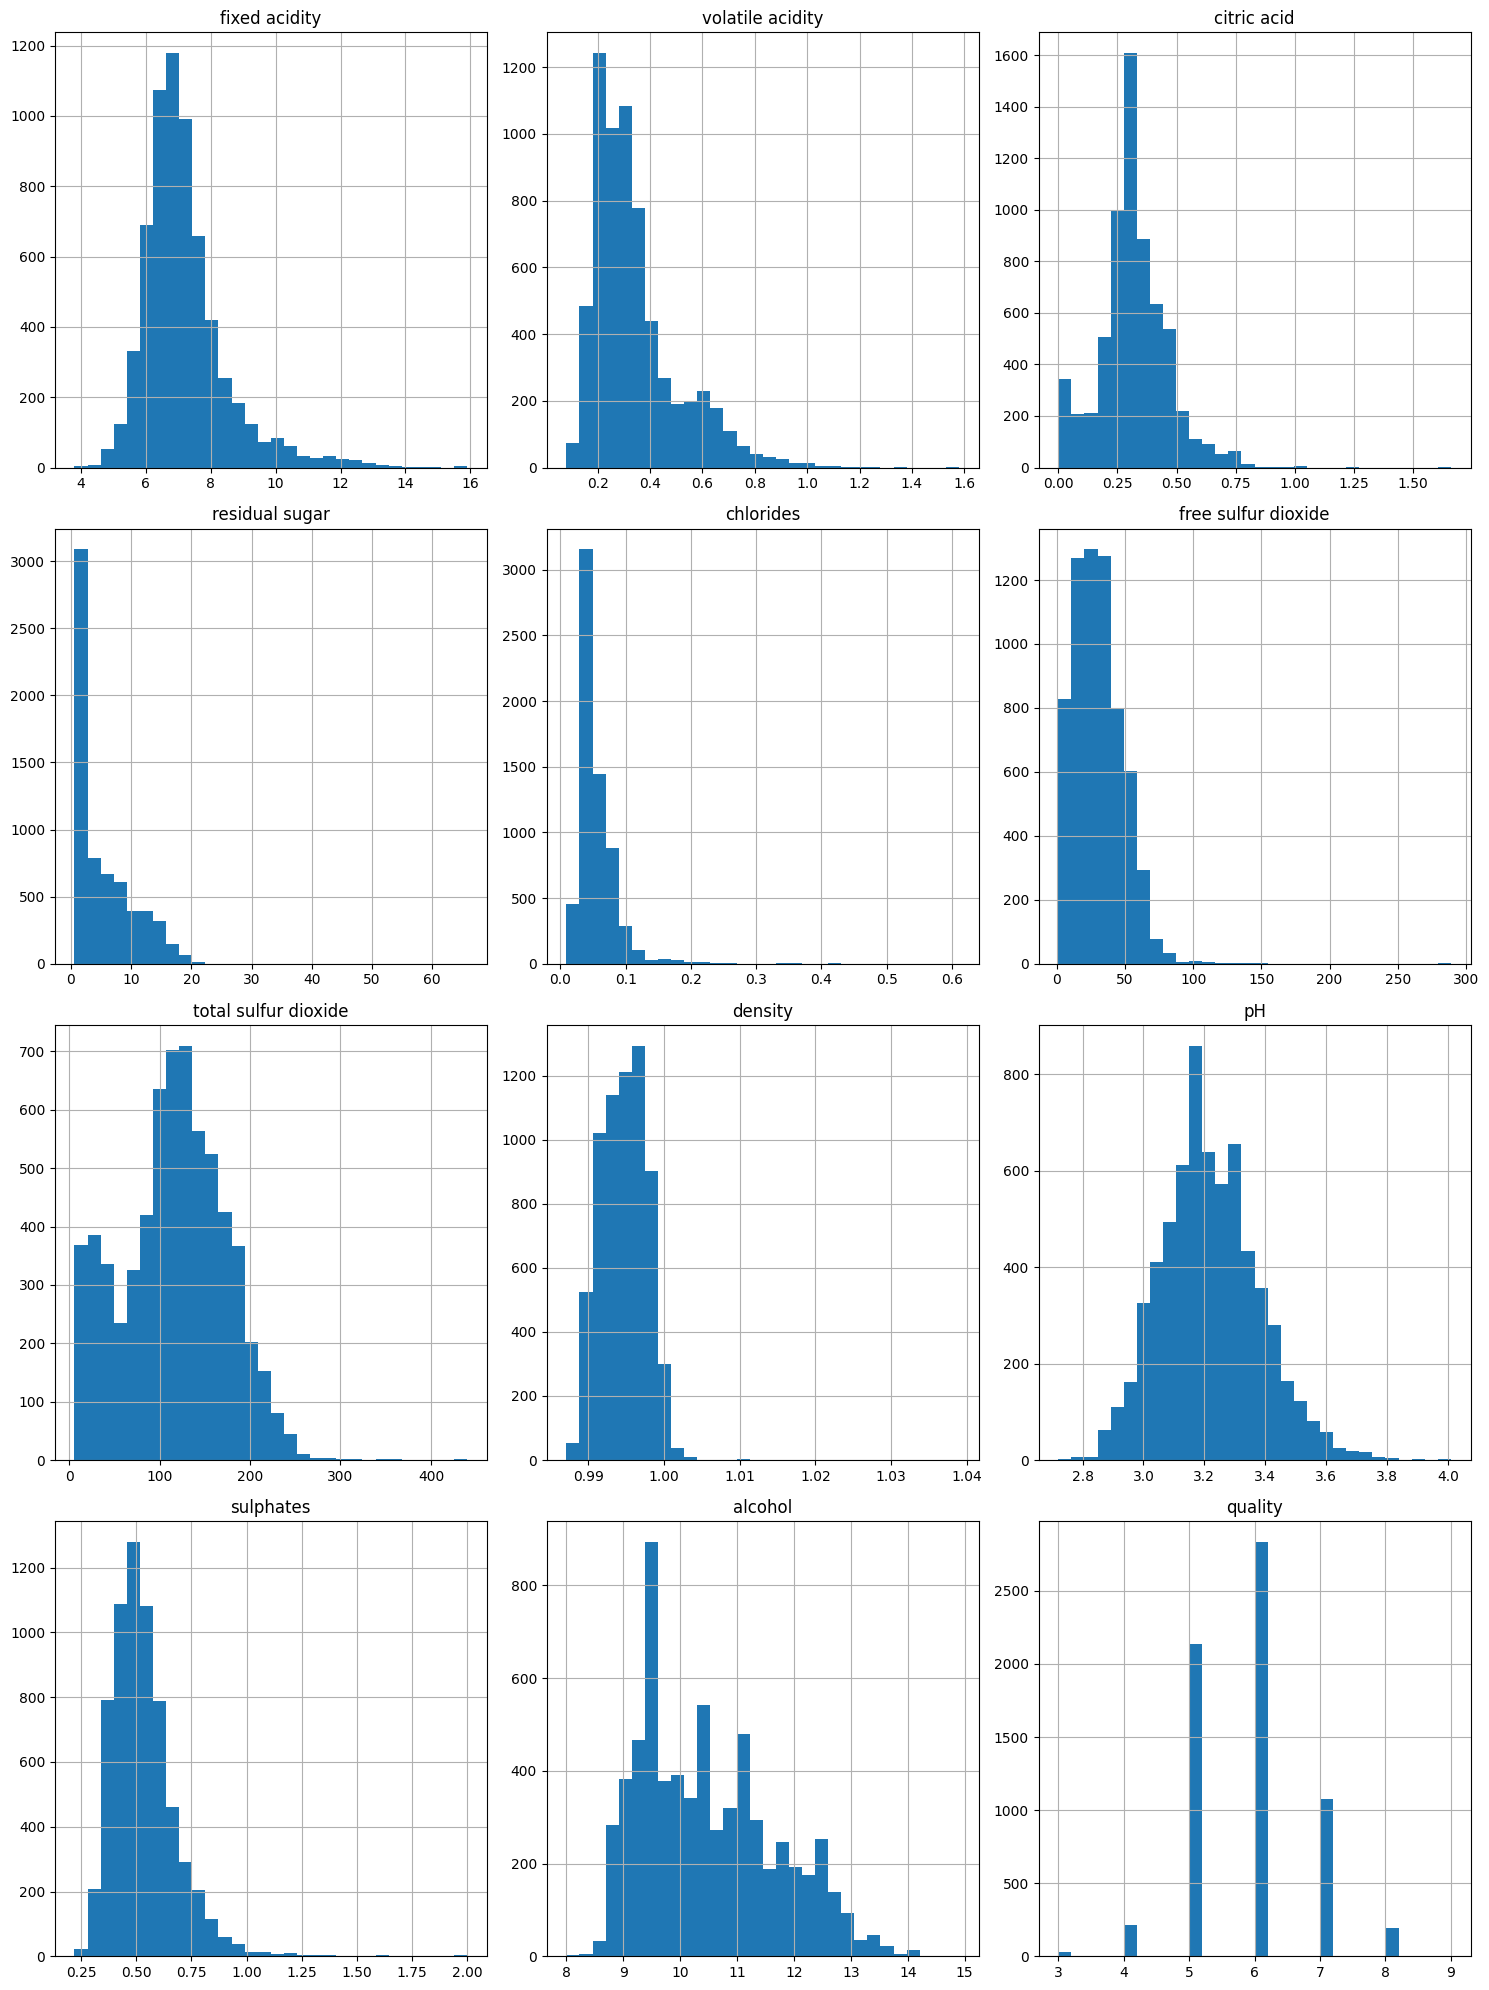

In [7]:
df = pd.read_csv('wine-missing.csv')
print( df )
print( df.columns )
fig, ax = plt.subplots( len( df.columns )//3, 3, figsize=(15,20) )
cnt = 0
for index in range( len( df.columns ) ):
	row = cnt // 3
	col = cnt % 3
	column = df.columns[index]
	if df[column].isnull().sum() > 0:
		print( f"{column} has {df[column].isnull().sum()} missing values")
		mean_value = df[column].mean()
	if column != 'type':
		df[column].hist( ax = ax[row][col], bins = 30 )
		ax[row][col].set_title( column )
		cnt += 1
# df.fillna();


# for index in range( len( df.columns ) ):
# 	column = df.columns[index]
# 	if df[column].isnull().values.any():
# 		df[column] = df[column].fillna( df[column].mean() )

df = df.dropna().reset_index(drop=True)
plt.tight_layout()
plt.show()

Θα λέγαμε ότι γενικότερα τα δεδομένα μας βρίσκονται σε καλή κατάσταση με τα περισσότερα να ακολοθούν κανονική ή χ^2 κατανομή με ελάχιστους outliers.

<BarContainer object of 3 artists>

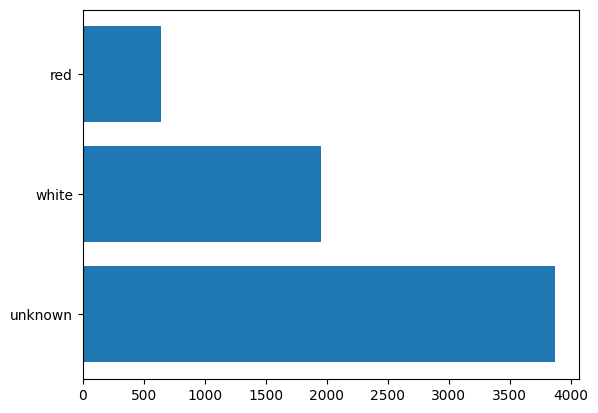

In [8]:
type_counts = df['type'].value_counts()
plt.barh( type_counts.index, type_counts.values)

Βλέπουμε ότι μας λείπουν πάνω από τις μισές τιμές

## Ερώτηση 2-3

In [9]:
type_df = df['type']
type_num = np.zeros( len( type_df ) )

for i in range( len( type_df ) ):
	if type_df[i] == "red":
		type_num[i] = 1
	elif type_df[i] == "white":
		type_num[i] = 0
	else:
		type_num[i] = 2

x_input = df.drop( columns = ["type"] ).to_numpy()

mask_known = ( type_num < 2 )
# mask_known.
x_input_known = x_input[mask_known]
y_input_known = type_num[mask_known]

x_input_unknown = x_input[~mask_known]
y_input_unknown = type_num[~mask_known]

print( y_input_known.shape )

(2591,)


## Ερώτηση 4

In [10]:
seed = 42
test_size = 0.3

In [11]:
x_train, x_test, y_train, y_test = train_test_split( x_input_known, y_input_known, test_size=test_size, random_state = seed, stratify = y_input_known )

## Ερώτηση 5

In [12]:
model = RandomForestClassifier( random_state = seed, n_jobs = -1 )
model.fit( x_train, y_train )

y_predict = model.predict( x_test )

ac_sc = accuracy_score( y_test, y_predict )
pr_sc = precision_score( y_test, y_predict )
re_sc = recall_score( y_test, y_predict )
f1_sc = f1_score( y_test, y_predict )
cm = confusion_matrix(y_test, y_predict)

print( f"Accuracy score: \t{ac_sc}")
print( f"Precision score:\t{pr_sc}")
print( f"Recall score:   \t{re_sc}")
print( f"F1 score:       \t{f1_sc}")

print( cm )


Accuracy score: 	0.9974293059125964
Precision score:	1.0
Recall score:   	0.9895833333333334
F1 score:       	0.9947643979057592
[[586   0]
 [  2 190]]


Γενικά το accuracy δουλεύει καλά μόνο στην περίπτωση που τα δεδομένα είναι ισορροπημένα, κάτι τετοιο δεν συμβαίνει εδώ. Το δείγματα του άσπρου κρασιού είναι πολύ λιγότερα από τα δείγματα του κόκκινου.

## Ερώτηση 6

In [13]:
model = RandomForestClassifier( random_state = seed, class_weight='balanced', n_jobs = -1 )
model.fit( x_train, y_train )

y_predict = model.predict( x_test )

ac_sc = accuracy_score( y_test, y_predict )
pr_sc = precision_score( y_test, y_predict )
re_sc = recall_score( y_test, y_predict )
f1_sc = f1_score( y_test, y_predict )

print( f"Accuracy score: \t{ac_sc}")
print( f"Precision score:\t{pr_sc}")
print( f"Recall score:   \t{re_sc}")
print( f"F1 score:       \t{f1_sc}")

Accuracy score: 	0.9987146529562982
Precision score:	1.0
Recall score:   	0.9947916666666666
F1 score:       	0.9973890339425587


Βάζοντας αυτό το όρισμα βοηθάει την επίδοση του ταξινομητή όταν έχουμε μη ισορροπημένες κλάσεις όπως το παράδειγμα μας.

## Ερώτημα 7-8-9-10

In [14]:
p_red = .65
p_white = .35

def createNTrainModel( x_input = x_input_known, y_input = y_input_known ):
    model = RandomForestClassifier( random_state = seed, class_weight = 'balanced', n_jobs = -1 )
    model.fit( x_input, y_input )

    return model


iters = 30
ans = 0

for i in range(iters):
    model = createNTrainModel( x_input = x_input_known, y_input = y_input_known )
    y_prob = model.predict_proba( x_input_unknown )[:, 1]
    mask_white  = y_prob < p_white
    mask_red    = y_prob > p_red
    mask_unknown = ( ~mask_red ) & ( ~mask_white )
    print(f"Iter {i+1}")
    print("  red_new_samples   :", red_new_samples)
    print("  white_new_samples :", white_new_samples)
    print("  remain_unknown    :", mask_unknown.sum())
    print("  y_prob[min, max]  :", y_prob.min(), y_prob.max())
    red_new_samples = mask_red.sum()
    white_new_samples = mask_white.sum()
    if red_new_samples + white_new_samples == 0:
    #all unknown wines have been classified
        break
    
    x_input_known = np.vstack( [x_input_known, x_input_unknown[mask_white]] )
    y_input_known = np.hstack( [y_input_known, np.zeros( white_new_samples )])

    x_input_known = np.vstack( [x_input_known, x_input_unknown[mask_red]] )
    y_input_known = np.hstack( [y_input_known, np.ones( red_new_samples )])

    

    x_input_unknown = x_input_unknown[mask_unknown]
    if x_input_unknown.shape[0] == 0:
        print( f"It took me { i + 1 } iterations.")
        ans = 1
        break

if ans:
    print( "All wines have been classified")
else:
    print( "Not all wines have been classified.")
  


Iter 1


NameError: name 'red_new_samples' is not defined

# ΜΕΡΟΣ 2

# Ερώτηση 1

In [ ]:
df = pd.read_csv('wine-full.csv')

df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


fixed acidity has 10 missing values
volatile acidity has 8 missing values
citric acid has 3 missing values
residual sugar has 2 missing values
chlorides has 2 missing values
pH has 9 missing values
sulphates has 4 missing values


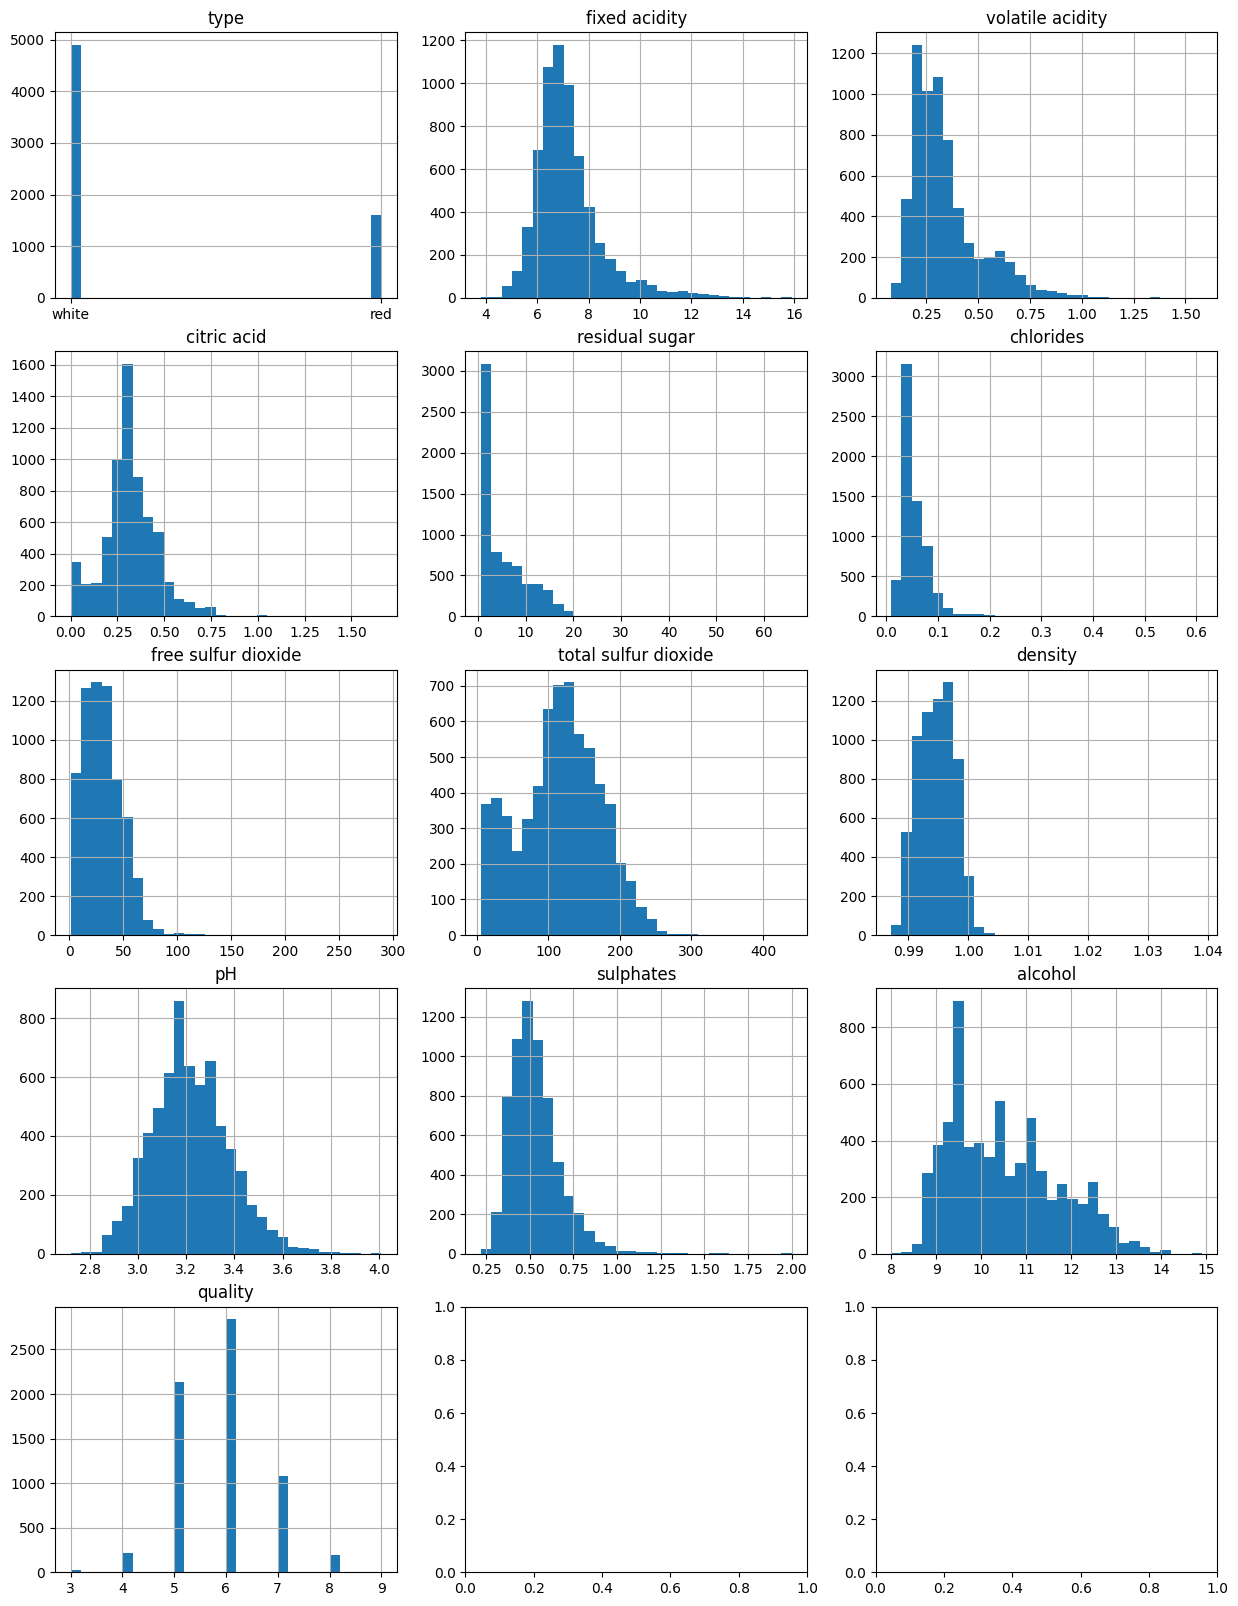

In [ ]:
fig, ax = plt.subplots( math.ceil( len( df.columns )/3 ), 3, figsize=(15,20) )
cnt = 0
for index in range( len( df.columns ) ):
	row = cnt // 3
	col = cnt % 3
	column = df.columns[index]
	if df[column].isnull().sum() > 0:
		print( f"{column} has {df[column].isnull().sum()} missing values")
		mean_value = df[column].mean()
	df[column].hist( ax = ax[row][col], bins = 30 )
	ax[row][col].set_title( column )
	cnt += 1

Βλέπουμε πως το γράφημα quality δεν είναι μοιρασμένο ισότιμα. Φαίνεται κυρίως η τιμή 6 να είναι η κυρίαρχη.

## Ερώτημα 2
Μπορούμε να δούμε σε αυτή την περίπτωση την συσχέτιση μεταξύ του είδους του κρασιού και της ποιότητας.

(array([4870.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

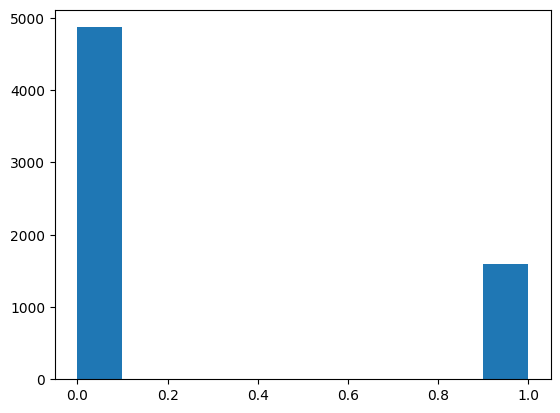

In [ ]:
df = df.dropna().reset_index(drop=True)

df['type'] = df['type'].replace({'white': "0", 'red': "1" } )
df["type"] = df['type'].astype(int)
plt.hist( df['type'])

In [ ]:
df.corr()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
type,1.000000,0.488552,0.653374,-0.185892,-0.349358,0.512705,-0.472653,-0.700521,0.391437,0.328474,0.486715,-0.035095,-0.119185
fixed acidity,0.488552,1.000000,0.221066,0.323744,-0.113442,0.299104,-0.283485,-0.330543,0.459713,-0.251121,0.301263,-0.096190,-0.076174
volatile acidity,0.653374,0.221066,1.000000,-0.377512,-0.196677,0.377995,-0.353402,-0.414729,0.272101,0.260134,0.225656,-0.039528,-0.266677
citric acid,-0.185892,0.323744,-0.377512,1.000000,0.142324,0.039412,0.132271,0.194398,0.097068,-0.327860,0.059070,-0.010056,0.084926
residual sugar,-0.349358,-0.113442,-0.196677,0.142324,1.000000,-0.128814,0.403449,0.495684,0.551494,-0.266481,-0.185616,-0.359132,-0.034654
chlorides,0.512705,0.299104,0.377995,0.039412,-0.128814,1.000000,-0.195428,-0.279602,0.363108,0.044653,0.396240,-0.257664,-0.200553
free sulfur dioxide,-0.472653,-0.283485,-0.353402,0.132271,0.403449,-0.195428,1.000000,0.721476,0.025113,-0.145164,-0.188947,-0.179477,0.054924
total sulfur dioxide,-0.700521,-0.330543,-0.414729,0.194398,0.495684,-0.279602,0.721476,1.000000,0.031419,-0.237204,-0.275878,-0.264385,-0.041598
density,0.391437,0.459713,0.272101,0.097068,0.551494,0.363108,0.025113,0.031419,1.000000,0.012525,0.260019,-0.687432,-0.304447
pH,0.328474,-0.251121,0.260134,-0.327860,-0.266481,0.044653,-0.145164,-0.237204,0.012525,1.000000,0.190864,0.120473,0.018403


Σύμφωνα με την συσχέτιση βλέπουμε ότι παίζει αδύναμο ρόλο στην ποιότητα του κρασιού. Εκτυπώνουμε και τα γραφήματα και βλέπουμε τις κατανομές

<bound method Figure.tight_layout of <Figure size 1000x700 with 1 Axes>>

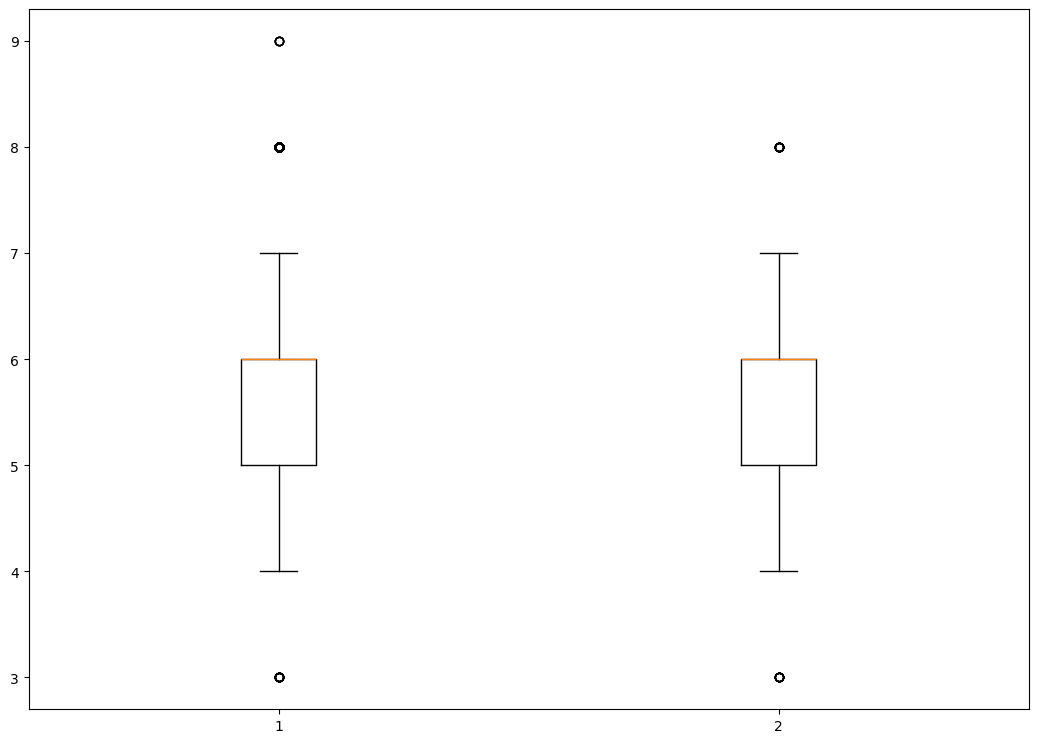

In [ ]:
mask_white = df['type'] == 0
mask_red = df['type'] == 1
quality_df = df['quality']


# wilcoxon( df['type'][mask_white], df['type'][mask_red])
d = [quality_df[mask_white], quality_df[mask_red]]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d)
fig.tight_layout()

# plt.hist( df['quality'][mask_white], width = 0.7 )

In [ ]:
t_stat, p_t = ttest_ind(quality_df[mask_white], quality_df[mask_red], equal_var=False)
u_stat, p_u = mannwhitneyu( quality_df[mask_white], quality_df[mask_red], alternative='two-sided' )
print("Mann-Whitney p-value:", p_u)
print("T test: ", p_t )

Mann-Whitney p-value: 4.520610308861048e-23
T test:  1.2109831717990665e-23


Σύμφωνα με τις μετρικές και σύμφωνα με το διάγραμμα δεν μπορούμε να βγάλουμε κάποιο συμπέρασμα. Οπότε θα λέγαμε ότι το κόκκινο και το άσπρο είναι το ίδιο καλό.

## Ερώτηση 3

Εδώ θα εκτυπώσουμε το διάγραμμα ζάχαρη-ποιότητα

6463


/tmp/ipykernel_42240/2788290552.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


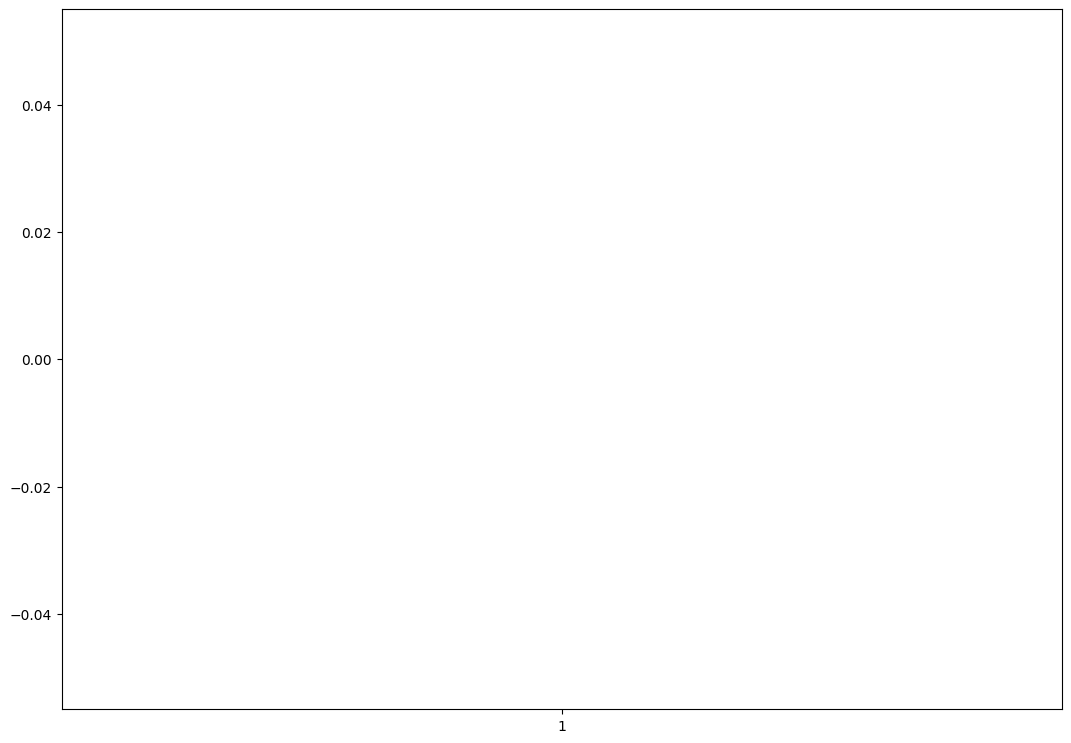

In [ ]:
d = []
quality_df = df['quality']
# print( len( quality_df.values ) )
values = df['quality'].unique()
for val in df['quality'].unique:
    mask = df['quality'] == val
    # d.append( df['residual sugar'][mask])
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d)
fig.tight_layout()